Yet another 10,000 foot view @ [`https://github.com/squillero/10k`](https://github.com/squillero/10k)  
Copyright **©** 2022 Giovanni Squillero `<squillero@polito.it>`  
Free for personal or classroom use; see the [license](https://github.com/squillero/10k/blob/main/LICENSE.md) for details.  

------------------------------------------------------------

# Neural Networks with PyTorch

In [1]:
import logging

logging.basicConfig(format="%(message)s", level=logging.INFO)

In [2]:
from itertools import product
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
import torch

# from torch import nn, optim
# from torch.nn import functional as F

logging.info(
    f"Using torch v{torch.__version__} [{'CUDA on ' + torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else 'CPU'}]"
)

Using torch v1.12.1 [CPU]


## Create a large, not-so-easy dataset

,x0,x1,class
0,1.001384,1.110837,0
1,-0.956223,-0.674684,0
2,0.616018,-1.293180,1
3,-1.300775,-0.842216,0
4,1.881677,0.386079,0


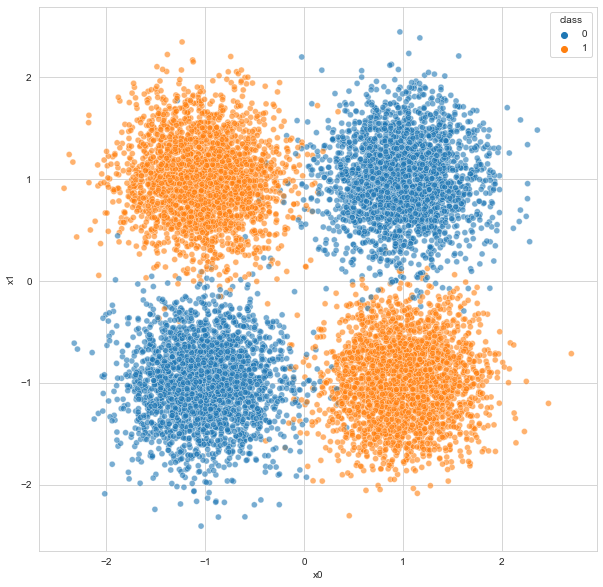

In [4]:
POINTS = 10_000
SCALE = 0.4

data = pd.DataFrame(
    np.concatenate(
        [
            np.random.normal(loc=1, scale=SCALE, size=(POINTS // 4, 2)) * [-1, -1],
            np.random.normal(loc=1, scale=SCALE, size=(POINTS // 4, 2)) * [1, 1],
            np.random.normal(loc=1, scale=SCALE, size=(POINTS // 4, 2)) * [-1, 1],
            np.random.normal(loc=1, scale=SCALE, size=(POINTS // 4, 2)) * [1, -1],
        ]
    ),
    columns=["x0", "x1"],
)
data["class"] = 1
data.loc[: POINTS // 2, "class"] = 0
data = data.sample(frac=1).reset_index(drop=True)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=data["x0"], y=data["x1"], hue=data["class"], alpha=0.6)
data.head()

## Let's PyTorch

### Define X and y

In [5]:
cut_point = int(POINTS * 0.8)
X_train = torch.tensor(data[:cut_point][["x0", "x1"]].to_numpy().astype(np.float32))
X_test = torch.tensor(data[cut_point:][["x0", "x1"]].to_numpy().astype(np.float32))
y_train = torch.squeeze(torch.tensor(data[:cut_point][["class"]].to_numpy().astype(np.float32)))
y_test = torch.squeeze(torch.tensor(data[cut_point:][["class"]].to_numpy().astype(np.float32)))
logging.info(f"Train size: {X_train.shape} / {y_train.shape}")
logging.info(f"Test size : {X_test.shape} / {y_test.shape}")

Train size: torch.Size([8000, 2]) / torch.Size([8000])
Test size : torch.Size([2000, 2]) / torch.Size([2000])


### Define the Neural Network

In [6]:
class MyFirstNN(torch.nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.i1 = torch.nn.Linear(n_features, 4)
        self.i2 = torch.nn.Linear(4, 2)
        self.o = torch.nn.Linear(2, 1)

    def forward(self, x):
        x = self.i1(x)
        x = torch.relu(x)
        x = self.i2(x)
        x = torch.relu(x)
        x = self.o(x)
        return torch.sigmoid(x)

In [7]:
nn = MyFirstNN(X_train.shape[1])
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(nn.parameters(), lr=0.001)

In [8]:
for epoch in tqdm(range(10_000)):
    y_pred = torch.squeeze(nn(X_train))
    train_loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
logging.info(train_loss)

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0332, grad_fn=<BinaryCrossEntropyBackward0>)


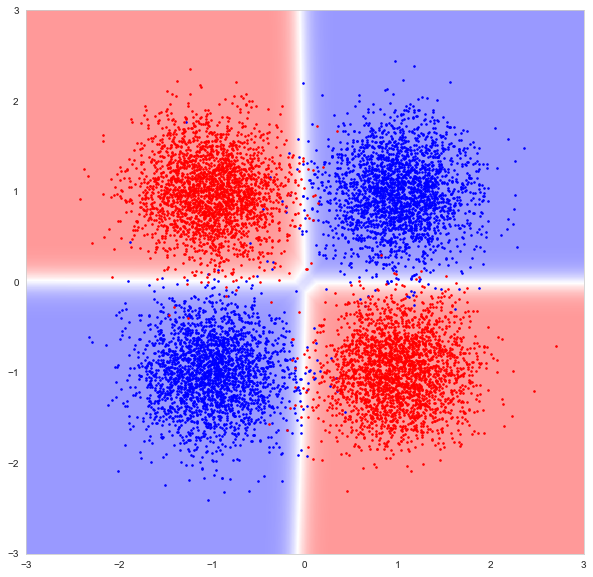

In [9]:
r = np.linspace(-3, 3, 1_000)
grid = [[x, y] for x, y in product(r, repeat=2)]
heat = nn(torch.Tensor(grid)).detach().numpy().reshape(len(r), len(r))
x1, x2 = np.meshgrid(r, r)
plt.figure(figsize=(10, 10))
plt.pcolormesh(x1, x2, heat, cmap="bwr", alpha=0.4, antialiased=True)
plt.scatter(
    x=data[data["class"] == 0]["x0"], y=data[data["class"] == 0]["x1"], marker=".", s=10, color="blue", label="Class 0"
)
plt.scatter(
    x=data[data["class"] == 1]["x0"], y=data[data["class"] == 1]["x1"], marker=".", s=10, color="red", label="Class 0"
)